In [ ]:
#Mounting google drive to access the dataset
from google.colab import drive

drive.mount('/content/gdrive')

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim



os.chdir('/content/gdrive/MyDrive/APS360 Project')

final_data_2  = np.load('CNN-LSTM Data.npy')
labels = np.load('CNN-LSTM Labels.npy')

torch.manual_seed(1) # set the random seed

final_data = torch.from_numpy(final_data_2)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class Model(nn.Module):
  def __init__(self, input_size):
    super(Model, self).__init__()

    # CNN LAYERS
    self.cnn_layers = nn.Sequential(

        # LAYER 1: 64 filters, kernel size 3, relu, batch norm, maxpooling size 2 (reduce dim)
        nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 2 128 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 3 256 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.MaxPool1d(kernel_size=2),
    )

    # LSTM LAYERS

    # 256 input from cnn, 100 units
    self.lstm_1 = nn.LSTM(input_size=256, hidden_size=100, batch_first=True)

    # 100 input from lstm1, 100 units, return false
    self.lstm_2 = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)

    self.fully_connected = nn.Sequential(

        # First Fully Connected Layer 100 Inputs, 100 Outputs
        nn.Linear(100, 100),
        nn.ReLU(),
        # Dropout Layer
        nn.Dropout(0.5),

        # Second Fully Connected Layer, 100 Inputs, 1 Output
        nn.Linear(100, 1)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1) # change shape to (batch_size, input_channels, time_steps)

    cnn_out = self.cnn_layers(x) #shape is now: (batch_size, 256, time_steps // 8)

    lstm_in = cnn_out.permute(0, 2 , 1) #change to batch_size, time_steps // 8, 256) for lstm inpiut

    lstm_out, _ = self.lstm_1(lstm_in)
    lstm_out, _ = self.lstm_2(lstm_out)

    fully_connected_in = lstm_out.view(-1, 100) # reshape to (batch_size, 100)
    fully_connected_out = self.fully_connected(fully_connected_in)
    fully_connected_out = fully_connected_out.view(-1)
    fully_connected_out = fully_connected_out.to(torch.float)

    return fully_connected_out


In [ ]:
def plot_train_val(epoch_list, train_loss, val_loss, title):
    # Plotting

  fig, ax = plt.subplots(figsize=(6, 5))

  plt.title(title+" Curve")

  colors = ["#8D99AE", "#EF233C"]
  # Plot the baseline text
  plt.text(
    epoch_list[-1] * 1.01,
    train_loss[-1],
    "Training " + title,
    color=colors[0],
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
  )
  plt.text(
    epoch_list[-1] * 1.01,
    val_loss[-1],
    "Validation " + title,
    color=colors[1],
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
  )
  # Hide the all but the bottom spines (axis lines)
  ax.spines["right"].set_visible(False)
  #ax.spines["left"].set_visible(False)
  ax.spines["top"].set_visible(False)

  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position("left")
  ax.xaxis.set_ticks_position("bottom")
  #ax.spines["bottom"].set_bounds(min(x), max(x))


  plt.plot(epoch_list, train_loss, label="Train", color = colors[0], linewidth = 2)
  plt.plot(epoch_list, val_loss, label="Validation", color = colors[1], linewidth = 2)
  plt.xlabel("Epoch")
  plt.ylabel(title)
  plt.legend(loc='best')
  plt.show()

In [ ]:
# Using map() and lambda
def listOfTuples(l1, l2):
    return list(map(lambda x, y:(x,y), l1, l2))

combined = (listOfTuples((torch.from_numpy(final_data_2)).to(torch.float), torch.from_numpy(labels).to(torch.float)))


In [ ]:
import random
random.shuffle(combined)

In [ ]:
len(combined)

5408

In [ ]:
5408 - 3244

2164

In [ ]:
1082

1082

In [ ]:
train_data = combined[:1024]
val_data = combined[1024:2048]



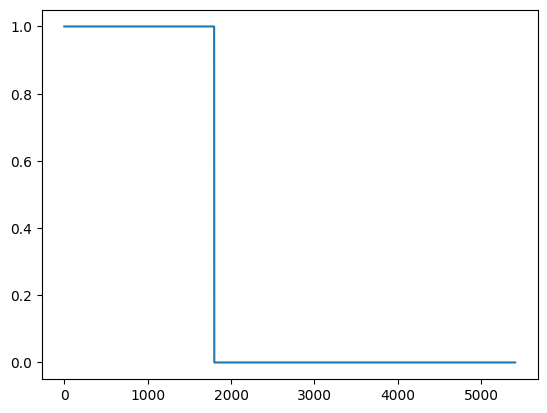

In [ ]:
plt.plot(labels)

In [ ]:

def train(model, data, val_data, batch_size = 64, lr = 0.01, epoch_num = 100):
  #train_queue = tf.train.slice_input_producer([data, train_labels],num_epochs=epoch_num,batch_size = batch_size,shuffle=True)

  train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size)
  #val_queue = tf.train.slice_input_producer([val_data, val_labels], num_epochs=epoch_num,batch_size = batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)

  criterion = nn.BCEWithLogitsLoss()
  optimizer  = torch.optim.Adam(model.parameters(),lr=lr)

  train_err, val_err, train_acc, val_acc = [], [], [], []

  train_t1_err, train_t2_err, val_t1_err, val_t2_err = [], [], [], []

  v_out = []

  epoch_list = range(epoch_num)
  num = 0

  train_loss = []
  val_loss = []
  loss_temp = []

  for epoch in epoch_list:

    error = 0
    count = 0
    t1_err = 0
    t2_err = 0

    for sample, labels in iter(train_loader):
      count += 1
      out = model(sample)         # Compute the output
      loss = criterion(out, labels) # Compute the total loss
      loss.backward()               # Backward pass
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # PyTorch clean up

      # Recalculating the out for the updated model step.
      out = model(sample)
      loss = criterion(out, labels)
      # Save the current training information
      loss_temp.append(float(loss)/batch_size)
      out = torch.sigmoid(out) # Gets the decimal estimations of fall / no fall
      estimate = torch.round(out) # Rounds each estimate to 1 or 0 --> fall or no fall

      type1_error = F.relu(estimate - labels) # Gets all the type 1 errors (predicted fall with no fall)
      type2_error = F.relu(labels - estimate) # Gets all the type 2 errors (predicted no fall with fall)


      diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
      temp = torch.sum(diff) # Sums all the error estimates
      error = temp.item() + error
      t1_err += torch.sum(type1_error).item()
      t2_err += torch.sum(type2_error).item()

    train_acc.append(1 - error/len(data))
    train_err.append(error/len(data))
    train_loss.append(sum(loss_temp)/len(loss_temp))

    train_t1_err.append(t1_err/len(data))
    train_t2_err.append(t2_err/len(data))
    error = 0
    t1_err = 0
    t2_err = 0

    # computing the error and accuracy on a validation set
    loss_temp = []
    count = 0
    v_out = torch.tensor([])
    for sample, labels in iter(val_loader):
      count += 1
      out = model(sample)
      loss = criterion(out, labels)
      out = torch.sigmoid(out) # Gets the decimal estimations of fall / no fall
      estimate = torch.round(out) # Rounds each estimate to 1 or 0 --> fall or no fall
      diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
      temp = torch.sum(diff) # Sums all the error estimates
      error = temp.item() + error

      loss_temp.append(float(loss)/batch_size)
      type1_error = F.relu(estimate - labels) # Gets all the type 1 errors (predicted fall with no fall)
      type2_error = F.relu(labels - estimate) # Gets all the type 2 errors (predicted no fall with fall)
      t1_err += torch.sum(type1_error).item()
      t2_err += torch.sum(type2_error).item()
      v_out = torch.cat((v_out, out))


    val_err.append(error/len(val_data))
    val_acc.append(1 - error/len(val_data))
    val_loss.append(sum(loss_temp)/len(loss_temp))

    val_t1_err.append(t1_err/len(val_data))
    val_t2_err.append(t2_err/len(val_data))

    print("\n\nEpoch ", epoch, "\nTraining Loss         : ",round(train_loss[-1],2), "\nTraining Accuracy     : ", round(train_acc[-1],2), "\nValidation Loss       : ", round(val_loss[-1],2), "\nValidation Accuracy   : ", round(val_acc[-1],2))

  v_out = v_out.view(-1).cpu().detach().numpy()
  plot_train_val(epoch_list, train_loss, val_loss, "Loss")
  plot_train_val(epoch_list, train_acc, val_acc, "Accuracy")
  plot_train_val(epoch_list, train_err, val_err, "Error")

  return v_out

In [ ]:
def get_acc(model, data, batch_size):
  correct = 0
  total = 0
  error = 0
  out_list = torch.tensor([])
  for img, labels in torch.utils.data.DataLoader(data, batch_size = batch_size):
    output = model(img)
    output = torch.sigmoid(output) # Gets the decimal estimations of fall / no fall
    estimate = torch.round(output) # Rounds each estimate to 1 or 0 --> fall or no fall
    diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
    temp = torch.sum(diff) # Sums all the error estimates
    error = temp.item() + error

    out_list = torch.cat((out_list, output))

  label_list = get_labels(data)
  out_list = out_list.view(-1).cpu().detach().numpy()
  out_list = [int(i) for i in out_list]
  confusion_matrix_2 = metrics.confusion_matrix(label_list, out_list)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])

  cm_display.plot()
  plt.show()

  return 1 - error / len(data)



Epoch  0 
Training Loss         :  0.13 
Training Accuracy     :  0.8 
Validation Loss       :  0.14 
Validation Accuracy   :  0.6


Epoch  1 
Training Loss         :  0.12 
Training Accuracy     :  0.8 
Validation Loss       :  0.13 
Validation Accuracy   :  0.6


Epoch  2 
Training Loss         :  0.1 
Training Accuracy     :  1.0 
Validation Loss       :  0.13 
Validation Accuracy   :  0.6


Epoch  3 
Training Loss         :  0.08 
Training Accuracy     :  1.0 
Validation Loss       :  0.15 
Validation Accuracy   :  0.6


Epoch  4 
Training Loss         :  0.09 
Training Accuracy     :  1.0 
Validation Loss       :  0.19 
Validation Accuracy   :  0.6


Epoch  5 
Training Loss         :  0.1 
Training Accuracy     :  1.0 
Validation Loss       :  0.26 
Validation Accuracy   :  0.6


Epoch  6 
Training Loss         :  0.13 
Training Accuracy     :  1.0 
Validation Loss       :  0.41 
Validation Accuracy   :  0.6


Epoch  7 
Training Loss         :  0.21 
Training Accuracy     :  1.0

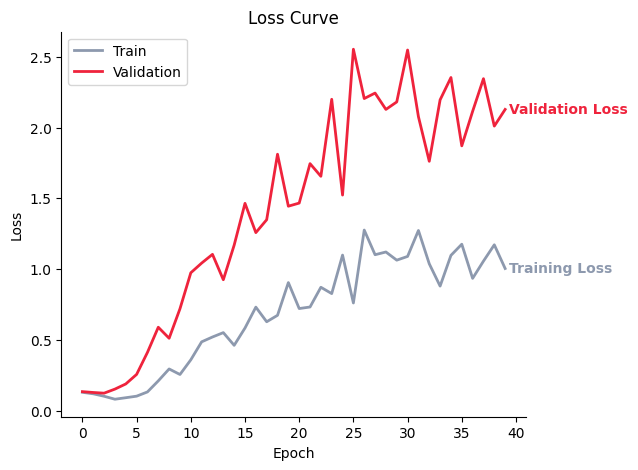

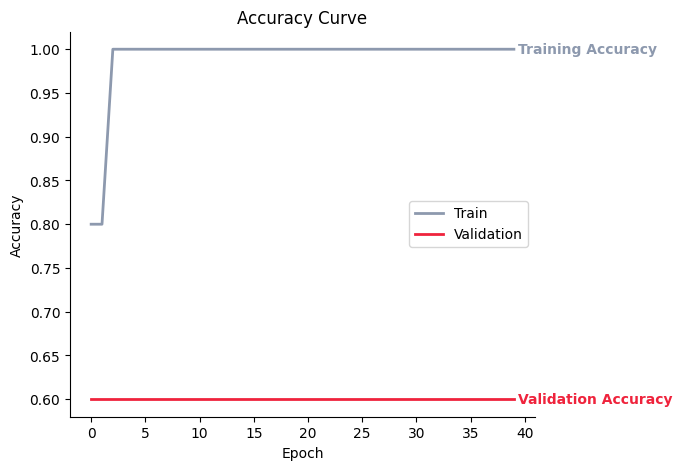

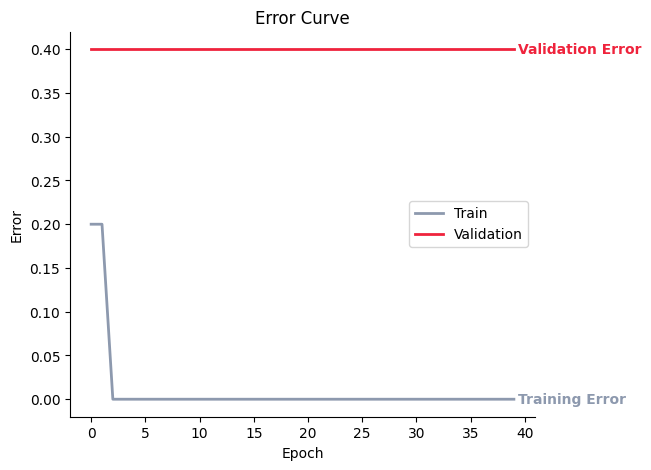

In [ ]:


torch.manual_seed(1) # set the random seed
model = Model(56)

reduced_train = train_data[:5]
reduced_val = val_data[:5]

v_out_reduced = train(model, reduced_train, reduced_val, batch_size = 5, lr = 0.01, epoch_num = 40)

In [ ]:
train_data = combined[2164:]
val_data = combined[:1082]
test_data = combined[1082:2164]




Epoch  0 
Training Loss         :  0.0 
Training Accuracy     :  0.98 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Va

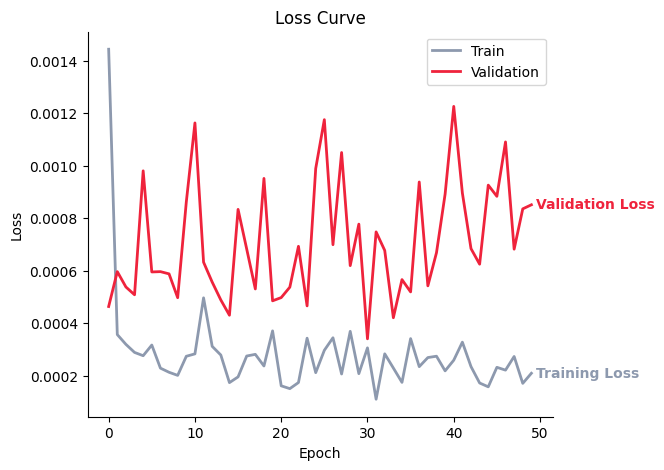

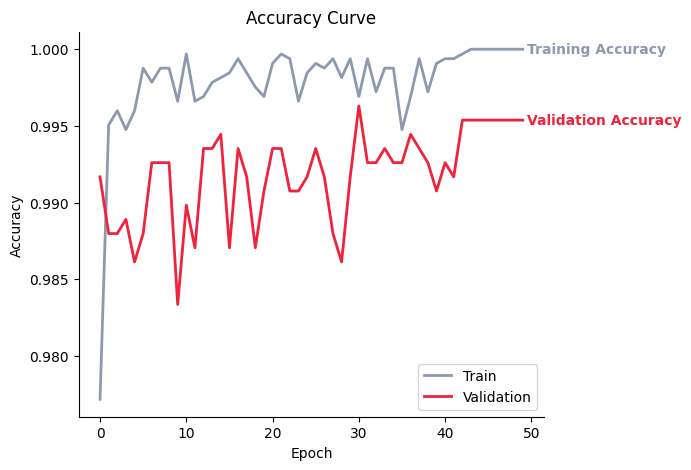

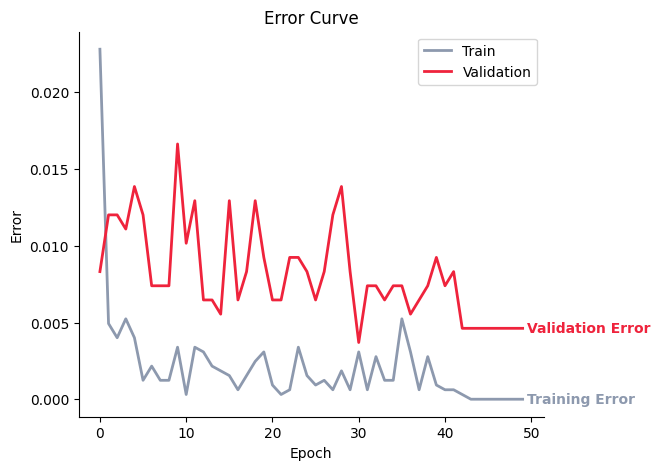

In [ ]:
model = Model(56)

v_out = train(model, train_data, val_data, batch_size = 64, lr = 0.01, epoch_num = 50)

In [ ]:
def get_labels(data):
  list = []
  for elem in data:
    list.append(int(elem[-1]))
  return list

In [ ]:
v_labels = get_labels(val_data)

In [ ]:
from sklearn import metrics

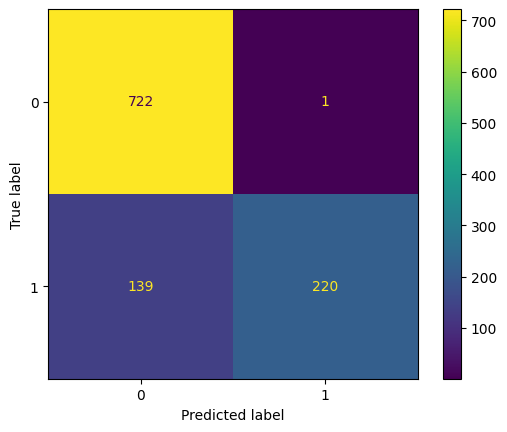

In [ ]:
v_out = [int(i) for i in v_out]
confusion_matrix = metrics.confusion_matrix(v_labels, v_out)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

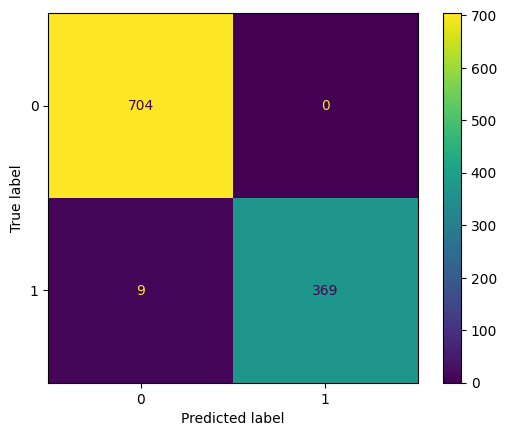

0.9981515711645101

In [ ]:

get_acc(model, test_data, 64)

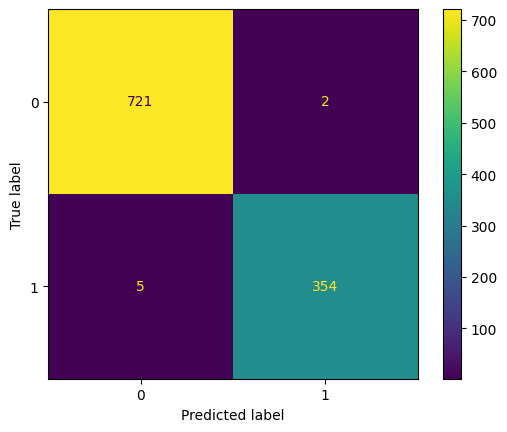

0.9944547134935305

In [ ]:
get_acc(model, val_data, 64)



Epoch  0 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation 

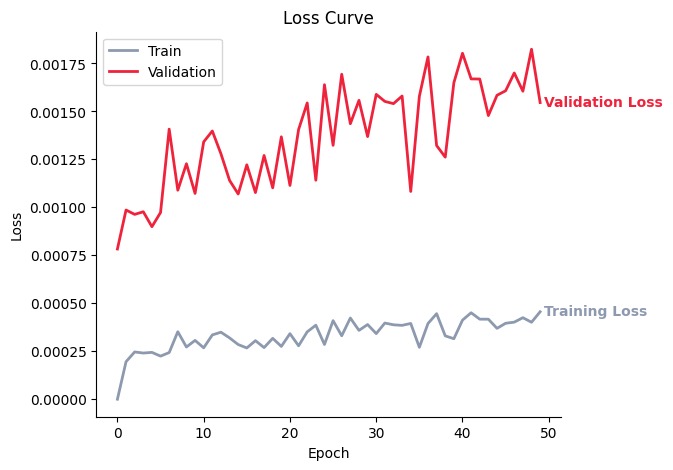

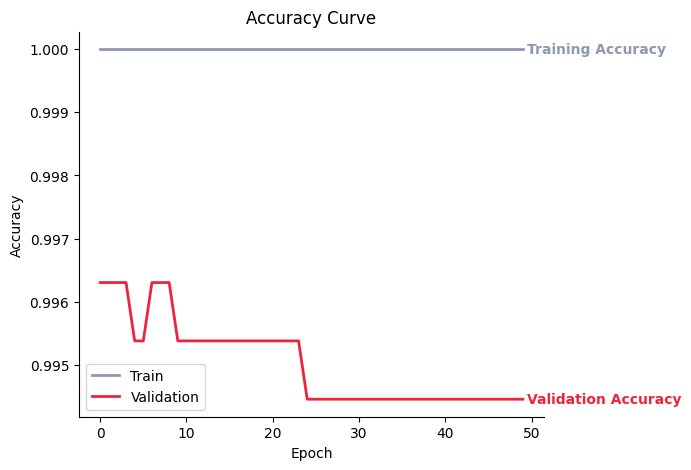

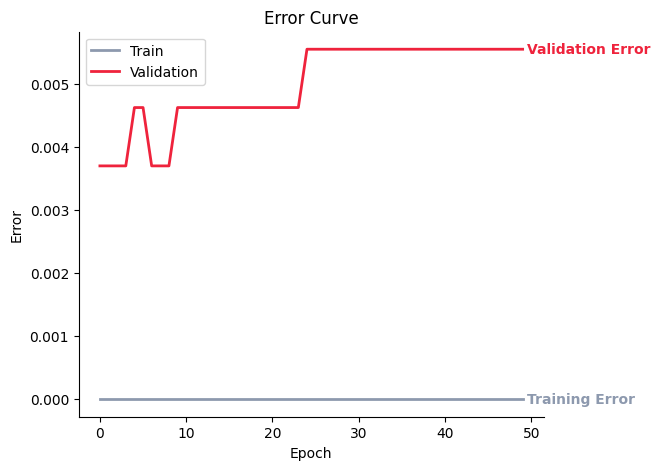

In [ ]:
model_2 = Model(56)

v_out_2 = train(model, train_data, val_data, batch_size = 64, lr = 0.001, epoch_num = 50)

In [ ]:
get_acc(model_2, train_data, 64)

0.657213316892725

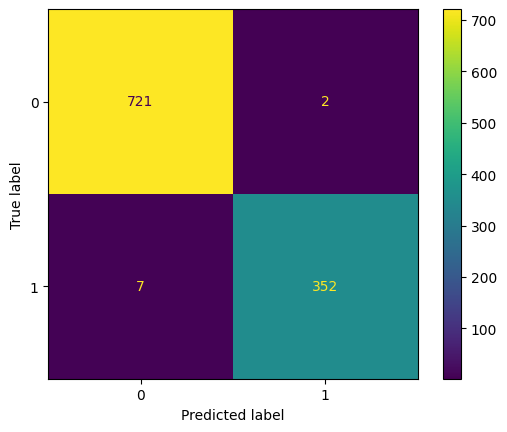

In [ ]:
v_out_2 = [int(i) for i in v_out_2]
confusion_matrix_2 = metrics.confusion_matrix(v_labels, v_out_2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [ ]:
get_acc(model_2, test_data, 64)

0.6358595194085028

In [ ]:
get_acc(model_2, train_data, 64)

0.6639950678175093

In [ ]:
get_acc(model_2, train_data, 64)

0.6612207151664611

In [ ]:
get_acc(model_2, val_data, 64)

0.6598890942698706

In [ ]:
D11 = np.load('D11_Data.npy')

In [ ]:
D11.shape

(190, 14, 56)

In [ ]:
d11_labels = torch.zeros(190)

In [ ]:
def listOfTuples(l1, l2):
    return list(map(lambda x, y:(x,y), l1, l2))

d11_labelled = (listOfTuples((torch.from_numpy(D11)).to(torch.float), d11_labels.to(torch.float)))


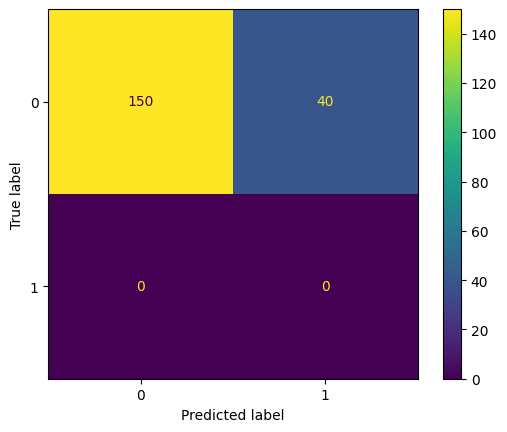

In [ ]:
acc = get_acc(model, d11_labelled, 64)

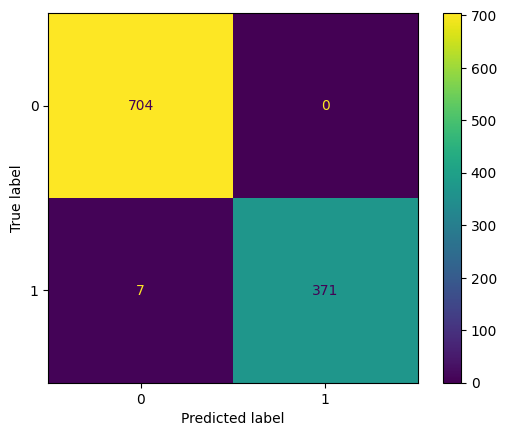

In [ ]:
acc = get_acc(model, test_data, 64)

In [ ]:
print(acc)

0.9981515711645101


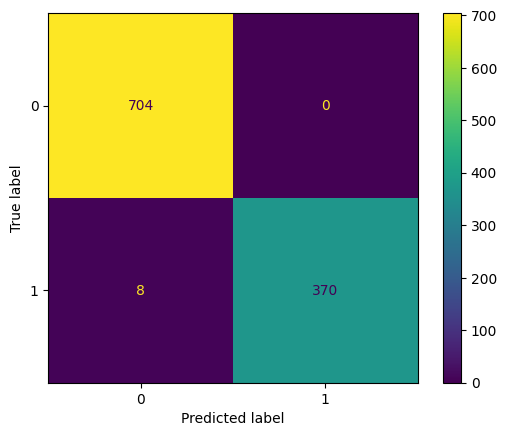

0.9981515711645101

In [ ]:
get_acc(model, test_data, 64)

In [ ]:
err = (1 - acc)* 190
err

47.0